<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Expected_goals_MEGA_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data loaded successfully!
📊 Dataset shape: (6543, 27)

First 5 rows:
   Unnamed: 0        xG                      Date     PlayerId       TeamId  \
0           1  0.059171  2024-08-11T14:04:16.374Z  Rui Modesto  AIK Fotboll   
1           2  0.066250  2024-08-11T14:06:49.382Z    A. Manneh  Mjällby AIF   
2           3  0.049034  2024-08-11T14:15:58.759Z    E. Stroud  Mjällby AIF   
3           4  0.050156  2024-08-11T14:20:07.915Z  A. Salétros  AIK Fotboll   
4           5  0.054026  2024-08-11T14:26:48.973Z    I. Pittas  AIK Fotboll   

      HomeTeam     AwayTeam  timeMin  timeSec     x  ...   Bodypart  isGoal  \
0  AIK Fotboll  Mjällby AIF        3       51  90.6  ...       Head   False   
1  AIK Fotboll  Mjällby AIF        6       24  79.6  ...  RightFoot   False   
2  AIK Fotboll  Mjällby AIF       15       33  90.7  ...   LeftFoot   False   
3  AIK Fo

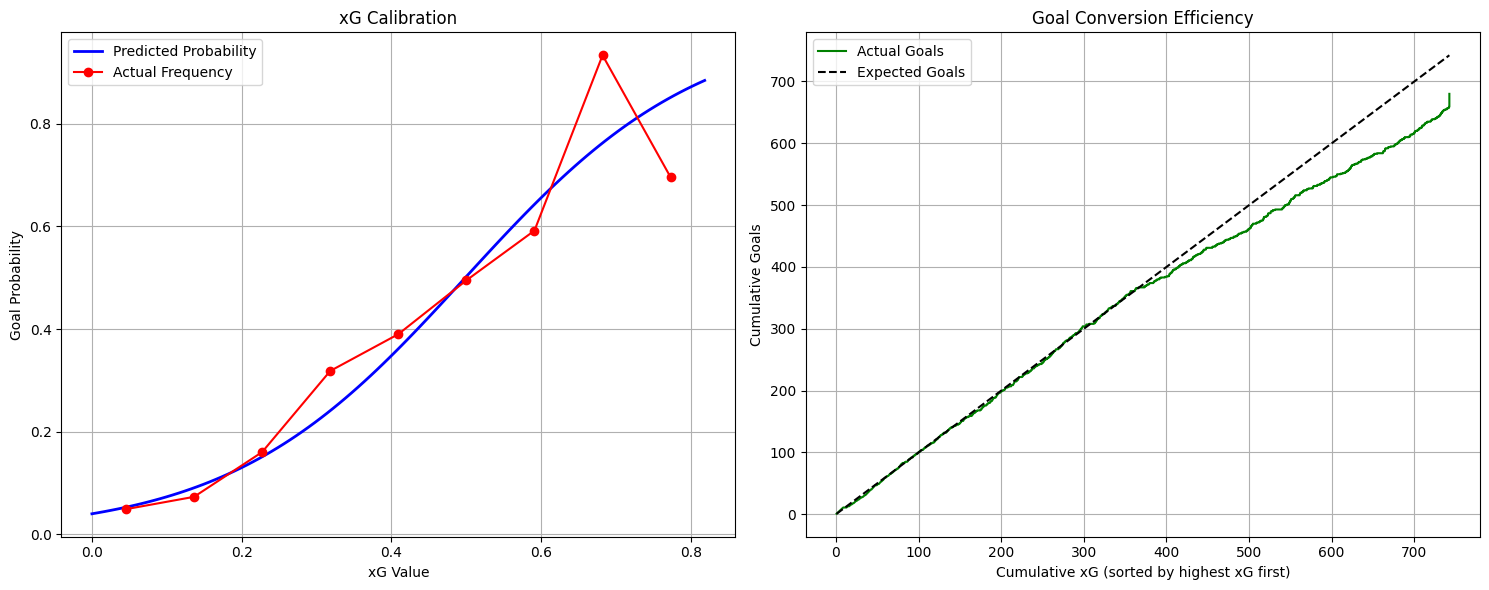

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    r2_score,
    roc_auc_score,
    brier_score_loss,
    mean_absolute_error
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from google.colab import drive
import os

# 1. Mount Google Drive and load data
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Recruitment/Allsvenskan 2024.xlsx'

try:
    # Load data with error handling
    df = pd.read_excel(file_path)
    print("✅ Data loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())

    # 2. Verify and prepare data
    required_cols = {'xG', 'isGoal'}
    if not required_cols.issubset(df.columns):
        missing = required_cols - set(df.columns)
        raise ValueError(f"❌ Missing required columns: {missing}")

    # Clean data
    df = df.dropna(subset=['xG', 'isGoal'])
    xG = df['xG'].values
    goals = df['isGoal'].astype(int).values

    print(f"\n📈 Data stats:")
    print(f"Total shots: {len(xG)}")
    print(f"Total goals: {goals.sum()} ({goals.mean():.1%})")
    print(f"Average xG: {xG.mean():.3f}")

    # 3. Enhanced Lyapunov Exponent calculation
    def safe_lyapunov(xG, goals, eps=0.15, max_pairs=1000):
        n = len(xG)
        divergences = []
        pair_count = 0

        for i in range(n):
            for j in range(i+1, min(i+100, n)):  # Compare nearby shots
                if abs(xG[i] - xG[j]) < eps:
                    d0 = abs(goals[i] - goals[j]) + 1e-6  # Avoid zero
                    dt = abs(goals[i+1] - goals[j+1]) if (i+1 < n and j+1 < n) else d0
                    dt = max(dt, 1e-6)
                    divergences.append(np.log(dt / d0))
                    pair_count += 1
                    if pair_count >= max_pairs:
                        break
            if pair_count >= max_pairs:
                break

        if not divergences:
            return 0

        finite_div = [d for d in divergences if np.isfinite(d)]
        return np.median(finite_div) if finite_div else 0  # More robust than mean

    # 4. Calculate comprehensive metrics
    metrics = {
        'Lyapunov Exponent': safe_lyapunov(xG, goals),
        'MAE': mean_absolute_error(goals, xG),
        'R²': r2_score(goals, xG),
        'AUC-ROC': roc_auc_score(goals, xG),
        'Brier Score': brier_score_loss(goals, xG),
        'Goal Rate': goals.mean(),
        'xG per Goal': xG.sum() / goals.sum() if goals.sum() > 0 else np.nan,
        'Calibration Error': np.mean(np.abs(np.clip(xG, 0, 1) - goals))
    }

    # 5. Print formatted results
    print("\n🔍 Unpredictability Metrics:")
    for name, value in metrics.items():
        if name in ['AUC-ROC', 'Goal Rate']:
            print(f"{name:<15}: {value:.3f} ({value:.1%})")
        elif name == 'Brier Score':
            print(f"{name:<15}: {value:.4f} (0=perfect, 0.25=random)")
        elif name == 'Lyapunov Exponent':
            print(f"{name:<15}: {value:.3f} (>0=chaotic, 0=stable)")
        else:
            print(f"{name:<15}: {value:.4f}")

    # 6. Advanced visualizations
    plt.figure(figsize=(15, 6))

    # Plot 1: Goal probability curve
    plt.subplot(1, 2, 1)
    lr = LogisticRegression().fit(xG.reshape(-1, 1), goals)
    x_test = np.linspace(0, max(xG), 100).reshape(-1, 1)
    y_proba = lr.predict_proba(x_test)[:, 1]
    plt.plot(x_test, y_proba, 'b-', lw=2, label='Predicted Probability')

    # Empirical goal rates
    bins = np.linspace(0, max(xG), 10)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    empirical = [goals[(xG >= bins[i]) & (xG < bins[i+1])].mean()
                for i in range(len(bins)-1)]
    plt.plot(bin_centers, empirical, 'ro-', label='Actual Frequency')

    plt.xlabel('xG Value')
    plt.ylabel('Goal Probability')
    plt.title('xG Calibration')
    plt.legend()
    plt.grid(True)

    # Plot 2: Cumulative goals vs xG
    plt.subplot(1, 2, 2)
    sorted_idx = np.argsort(xG)[::-1]
    cum_goals = np.cumsum(goals[sorted_idx])
    cum_xG = np.cumsum(xG[sorted_idx])
    plt.plot(cum_xG, cum_goals, 'g-', label='Actual Goals')
    plt.plot(cum_xG, cum_xG, 'k--', label='Expected Goals')
    plt.xlabel('Cumulative xG (sorted by highest xG first)')
    plt.ylabel('Cumulative Goals')
    plt.title('Goal Conversion Efficiency')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ File not found at: {file_path}")
    print("Available files in directory:")
    print(os.listdir('/content/drive/MyDrive/Recruitment'))
except Exception as e:
    print(f"❌ Error: {str(e)}")
    if 'df' in locals():
        print("\nData columns available:")
        print(df.columns.tolist())